Credit goes to https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb for the steps to use graph_tool in Colab.

In [ ]:
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install gravis

In [ ]:
from graph_tool.all import *

g = load_graph("HepPh_with_louvain_and_label.graphml")

In [ ]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import numpy as np

date_cutoffs = []

curr_date = datetime.strptime("1995-06-01", "%Y-%m-%d").date()
while curr_date.strftime("%Y-%m-%d") < "2000-06-01":
    date_cutoffs.append(curr_date.strftime("%Y-%m-%d"))
    curr_date += relativedelta(months=+2)

In [ ]:
import random
from tabulate import tabulate
from collections import Counter
random.seed()

def LabelPropagation(G):
    G_copy = G.copy()
    G_copy.set_directed(False)
    comps, hist = label_components(G_copy)
    assert(len(hist) == 1)

    labels = {}
    for i in G_copy.iter_vertices():
        labels[i] = [i]

    neighbours = {}
    for i in G_copy.iter_vertices():
        neighbours[i] = G_copy.get_all_neighbours(i)

    vert_order = [v for v in G_copy.iter_vertices()]
    while True:
        tmp_label_map = []
        for i in G_copy.iter_vertices():
            if labels[i][-1] not in tmp_label_map:
                tmp_label_map.append(labels[i][-1])
        print(f"Number of labels: {len(tmp_label_map)}")

        random.shuffle(vert_order)
        for v in vert_order:
            neighbouring_labels = Counter([labels[n][-1] for n in neighbours[v]])
            tie_break = []
            max_occur = neighbouring_labels.most_common(1)[0][1]
            for i in neighbouring_labels.most_common():
                if i[1] == max_occur:
                    tie_break.append(i[0])
                else:
                    break
            labels[v].append(random.choice(tie_break))

        for v in G_copy.iter_vertices():
            neighbouring_labels = Counter([labels[n][-1] for n in neighbours[v]])
            tie_break = []
            max_occur = neighbouring_labels.most_common(1)[0][1]
            for i in neighbouring_labels.most_common():
                if i[1] == max_occur:
                    tie_break.append(i[0])
                else:
                    break
            if labels[v][-1] not in tie_break:
                print(v)
                break
        else:
            break
    comms = G.new_vp("int")
    label_map = {}
    count = 0
    for i in G_copy.iter_vertices():
        if labels[i][-1] not in label_map:
            label_map[labels[i][-1]] = count
            count += 1
        comms[i] = label_map[labels[i][-1]]
    return comms

Number of labels: 4806
21
Number of labels: 1261
32
Number of labels: 542
22
Number of labels: 349
198
Number of labels: 285
194
Number of labels: 242
201
Number of labels: 219
1190
Number of labels: 209
2365
Number of labels: 201
1357
Number of labels: 196
3747
Number of labels: 191
1352
Number of labels: 190
1802
Number of labels: 186
4272
Number of labels: 181
5493
Number of labels: 179
7445
Number of labels: 177
758
Number of labels: 176
762
Number of labels: 176
772
Number of labels: 175
16443
Number of labels: 174
783
Number of labels: 173
4654
Number of labels: 173
1294
Number of labels: 173
882
Number of labels: 173
Number of labels: 5344
13
Number of labels: 1350
29
Number of labels: 570
215
Number of labels: 393
32
Number of labels: 299
177
Number of labels: 260
173
Number of labels: 223
205
Number of labels: 207
327
Number of labels: 196
346
Number of labels: 186
4802
Number of labels: 183
568
Number of labels: 179
549
Number of labels: 175
766
Number of labels: 174
443
Numb

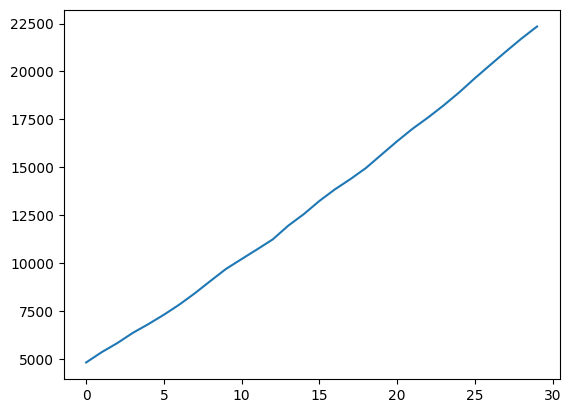

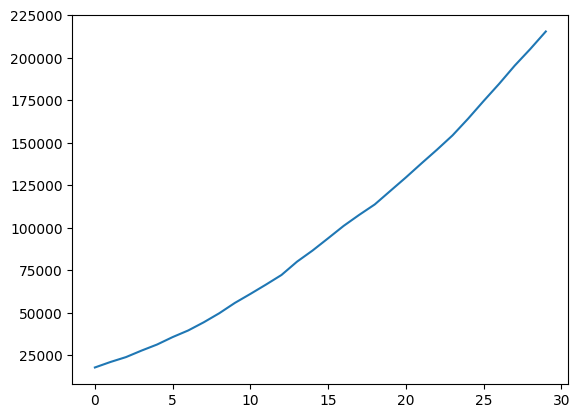

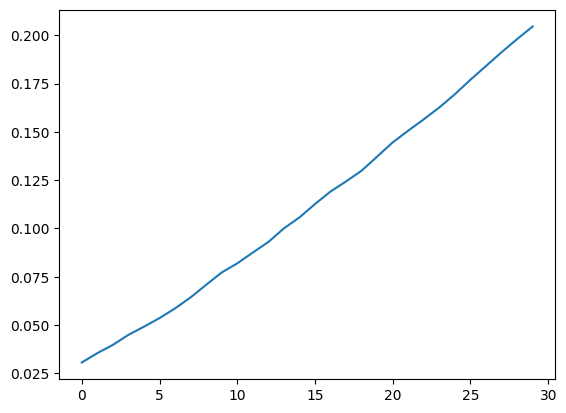

In [ ]:
from matplotlib import pyplot
import pickle

num_node_plot = [[],[]]
num_edge_plot = [[],[]]
avg_cc_plot = [[],[]]
community_assignments = []

for slice_idx, date_cutoff in enumerate(date_cutoffs):
    u = GraphView(g, vfilt=lambda v: g.vp.date[v] < date_cutoff)
    u = extract_largest_component(u, directed=False)

    num_node_plot[0].append(slice_idx)
    num_node_plot[1].append(u.num_vertices())

    num_edge_plot[0].append(slice_idx)
    num_edge_plot[1].append(u.num_edges())

    avg_cc_plot[0].append(slice_idx)
    avg_cc_plot[1].append(np.mean(local_clustering(u).a))

    mask_arr = LabelPropagation(u).ma

    label_temp = []
    for val,masked in np.column_stack((mask_arr.data, mask_arr.mask)):
        if masked:
            label_temp.append(-1)
        else:
            label_temp.append(val)

    community_assignments.append(label_temp)

pyplot.plot(num_node_plot[0], num_node_plot[1])
pyplot.show()
pyplot.plot(num_edge_plot[0], num_edge_plot[1])
pyplot.show()
pyplot.plot(avg_cc_plot[0], avg_cc_plot[1])
pyplot.show()

In [ ]:
from google.colab import files
import pickle

with open("original_community_assignments_Label.dump", "wb") as fp:
    pickle.dump(community_assignments, fp)

files.download('original_community_assignments_Label.dump')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from collections import Counter

with open("original_community_assignments_Label.dump", "rb") as f:
    community_assignments = pickle.load(f)

# Let us relabel ALL community labels to be unique (except -1s as they are not community labels)
relabelled_comm_assgns = []
curr_max_label = 0
for comm_assgn in community_assignments:
    old_labels = Counter(comm_assgn).keys()
    old_to_new_map = {-1:-1}
    for label in old_labels:
        if label == -1:
            continue
        old_to_new_map[label] = curr_max_label
        curr_max_label += 1

    new_comm_assgn = [old_to_new_map[old_label] for old_label in comm_assgn]
    relabelled_comm_assgns.append(new_comm_assgn)
print(len(relabelled_comm_assgns))
for i in relabelled_comm_assgns:
    print(len(i), end=" ")

30
30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 30341 

In [ ]:
# Now get the community sets per time slice
per_slice_comm_sets = []
for relabelled_comm_assgn in relabelled_comm_assgns:
    comm_members = {}
    for node_idx, comm_label in enumerate(relabelled_comm_assgn):
        if comm_label in comm_members:
            comm_members[comm_label].add(node_idx)
        else:
            comm_members[comm_label] = {node_idx}

    comm_sets = [[comm_label, comm_members[comm_label], True] for comm_label in comm_members.keys()]
    # sort the communities by size (desc)
    per_slice_comm_sets.append(sorted(comm_sets, key=lambda x: len(x[1]), reverse=True))

print(len(per_slice_comm_sets))
for i in per_slice_comm_sets:
    print(len(i), end=" ")

30
174 162 163 168 191 177 173 175 175 207 167 208 185 204 174 191 219 196 183 175 216 210 192 199 181 200 208 212 214 208 

In [ ]:
# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py
def jaccard_similarity(set1, set2):
    return float(len(set1.intersection(set2))) / float(len(set1.union(set2)))

# Find similar communities across time slices
for time_slice_idx in range(1, len(per_slice_comm_sets)):
    # Check for each of this slices' communities
    for new_comm_idx,new_comm in enumerate(per_slice_comm_sets[time_slice_idx]):
        # skip if -1
        if new_comm[0] == -1:
            continue

        max_jacque = 0.0
        best_prev_label = -1
        best_prev_label_idx = -1
        for prev_comm_idx,prev_comm in enumerate(per_slice_comm_sets[time_slice_idx-1]):
            # skip if used already or -1
            if prev_comm[0] == -1 or prev_comm[2] == False:
                continue

            # calculate jaccard similarity
            jacque = jaccard_similarity(new_comm[1], prev_comm[1])
            if jacque > max_jacque:
                max_jacque = jacque
                best_prev_label = prev_comm[0]
                best_prev_label_idx = prev_comm_idx

        if best_prev_label != -1:
            # remove prev and set new label
            per_slice_comm_sets[time_slice_idx-1][best_prev_label_idx][2] = False
            per_slice_comm_sets[time_slice_idx][new_comm_idx][0] = per_slice_comm_sets[time_slice_idx-1][best_prev_label_idx][0]
        else:
            # create new label
            per_slice_comm_sets[time_slice_idx][new_comm_idx][0] = curr_max_label
            curr_max_label += 1

In [ ]:
# Now we have the temporal communities
# Save and download them
with open("temporal_community_assignments_Label.dump", "wb") as fp:
    pickle.dump(per_slice_comm_sets, fp)

files.download('temporal_community_assignments_Label.dump')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of unique communities across slices: 1224


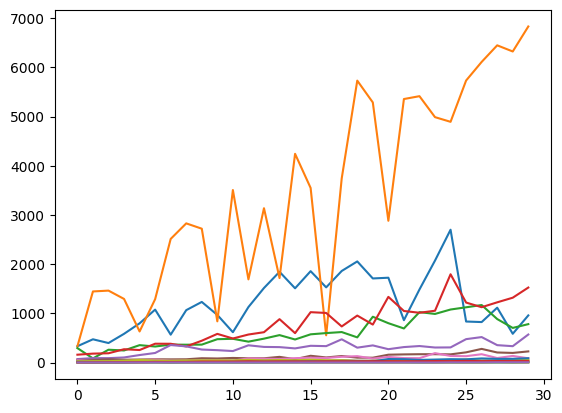

In [ ]:
# Lets plot the size of the communities over time!
temporal_comm_size_data = {}
for time_slice_idx,per_slice_comm_set in enumerate(per_slice_comm_sets):
    for comm in per_slice_comm_set:
        if comm[0] == -1:
            continue
        if comm[0] in temporal_comm_size_data:
            temporal_comm_size_data[comm[0]][0].append(time_slice_idx)
            temporal_comm_size_data[comm[0]][1].append(len(comm[1]))
        else:
            temporal_comm_size_data[comm[0]] = [[time_slice_idx],[len(comm[1])]]

print("Number of unique communities across slices:",len(temporal_comm_size_data.keys()))
for comm_label in temporal_comm_size_data.keys():
    if len(temporal_comm_size_data[comm_label][0]) < 30:
        continue
    # print(temporal_comm_size_data[comm_label][0], temporal_comm_size_data[comm_label][1])
    pyplot.plot(temporal_comm_size_data[comm_label][0], temporal_comm_size_data[comm_label][1])
pyplot.show()